In [144]:
!pip install datasets

  Using cached datasets-3.0.0-py3-none-any.whl.metadata (19 kB)
  Using cached filelock-3.16.0-py3-none-any.whl.metadata (3.0 kB)
  Using cached pyarrow-17.0.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (3.3 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached tqdm-4.66.5-py3-none-any.whl.metadata (57 kB)
  Using cached xxhash-3.5.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py312-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2024.6.1-py3-none-any.whl.metadata (11 kB)
  Using cached aiohttp-3.10.5-cp312-cp312-macosx_11_0_arm64.whl.metadata (7.5 kB)
  Using cached aiohappyeyeballs-2.4.0-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached frozenlist-1.4.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (12 kB)
  Using cached multidict-6.1.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (5.0 kB)
  Using cached yarl-1.11.1-cp312-cp312-macosx_11_0_arm64.whl.me

In [281]:
dataset = load_dataset("urdu-asr/common-voice-fleurs")
dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'sentence', 'gender'],
        num_rows: 14540
    })
    test: Dataset({
        features: ['audio', 'sentence', 'gender'],
        num_rows: 1616
    })
})

In [286]:
one = 0
two = 0
for k in dataset["train"]["sentence"]:
    if "ہو گا" in k:
        one += 1
    elif "ہوگا" in k:
        two += 1

In [287]:
one, two

(82, 87)

In [213]:
from datasets import load_dataset

dataset = load_dataset("urdu-asr/csalt-voice")

In [214]:
dataset

DatasetDict({
    validation: Dataset({
        features: ['audio', 'raw_transcription', 'transcription'],
        num_rows: 471
    })
})

In [215]:
csalt = dataset[]

In [216]:
import json

In [306]:
def clean(x, chars):
    clean_x = ''.join(c for c in x if c in chars)
    return clean_x.lstrip().rstrip()

diacritics = ['ّ', 'ً', 'ِ', 'ُ', 'َ']

with open("chars.json") as f:
    chars = json.load(f)
    chars = list(set(chars))
    chars = [char for char in chars if char not in diacritics]

In [326]:
with open("mapping_arl.json") as f:
    csalt = json.load(f)

csalt = [clean(x, chars) for x in list(csalt.values())]

with open("mapping_deepfake.json") as f:
    temp = json.load(f)

temp = [clean(x, chars) for x in list(temp.values())]
csalt.extend(temp)

In [327]:
with open("outputs/mms/mms-1b-ur/arl.json") as f:
    mms_1b = json.load(f)

with open("outputs/mms/mms-1b-ur/deepfake.json") as f:
    mms_1b.extend(json.load(f))

mms_1b = [clean(list(output.values())[0], chars) for output in mms_1b]

In [328]:
with open("outputs/whisper/whisper-large-v3-ur/arl.json") as f:
    whisper_large = json.load(f)

with open("outputs/whisper/whisper-large-v3-ur/deepfake.json") as f:
    whisper_large.extend(json.load(f))

whisper_large = [clean(list(output.values())[0], chars) for output in whisper_large]

In [329]:
with open("outputs/whisper/whisper-medium-ur/arl.json") as f:
    whisper_medium = json.load(f)

with open("outputs/whisper/whisper-medium-ur/deepfake.json") as f:
    whisper_medium.extend(json.load(f))

whisper_medium = [clean(list(output.values())[0], chars) for output in whisper_medium]

In [332]:
with open("outputs/seamlessm4t/seamless-m4t-medium-ur/arl.json") as f:
    seamless_medium = json.load(f)

with open("outputs/seamlessm4t/seamless-m4t-medium-ur/deepfake.json") as f:
    seamless_medium.extend(json.load(f))

seamless_medium = [clean(list(output.values())[0], chars) for output in seamless_medium]

In [333]:
with open("outputs/seamlessm4t/seamless-m4t-v2-large-ur/arl.json") as f:
    seamless_large = json.load(f)

with open("outputs/seamlessm4t/seamless-m4t-v2-large-ur/deepfake.json") as f:
    seamless_large.extend(json.load(f))

seamless_large = [clean(list(output.values())[0], chars) for output in seamless_large]

In [334]:
from difflib import SequenceMatcher
from collections import Counter

def find_all_wrong_words(csalt, pred):
    wrong_words = []
    
    for csalt_sentence, pred_sentence in zip(csalt, pred):
        csalt_words = csalt_sentence.split()
        pred_words = pred_sentence.split()
    
        s = SequenceMatcher(None, csalt_words, pred_words)
    
        for tag, i1, i2, j1, j2 in s.get_opcodes():
            if tag == 'replace':
                csalt_sub = csalt_words[i1:i2]
                pred_sub = pred_words[j1:j2]
                
                sub_matcher = SequenceMatcher(None, csalt_sub, pred_sub)
                for sub_tag, sub_i1, sub_i2, sub_j1, sub_j2 in sub_matcher.get_opcodes():
                    if sub_tag in ('replace', 'delete', 'insert'):
                        pred_word = ' '.join(pred_sub[sub_j1:sub_j2]) if sub_j2 > sub_j1 else '<null>'
                        if pred_word != '<null>':
                            wrong_words.append(pred_word)
            elif tag == 'insert':
                for word in pred_words[j1:j2]:
                    wrong_words.append(word)

    word_counts = Counter(wrong_words)
    return word_counts

mms_1b_ = find_all_wrong_words(csalt, mms_1b)
whisper_medium_ = find_all_wrong_words(csalt, whisper_medium)
whisper_large_ = find_all_wrong_words(csalt, whisper_large)
seamless_medium_ = find_all_wrong_words(csalt, seamless_medium)
seamless_large_ = find_all_wrong_words(csalt, seamless_large)

In [230]:
from difflib import SequenceMatcher
from collections import Counter

def find_all_wrong_words(csalt, pred):
    wrong_words = []
    
    for csalt_sentence, pred_sentence in zip(csalt, pred):
        csalt_words = csalt_sentence.split()
        pred_words = pred_sentence.split()
    
        s = SequenceMatcher(None, csalt_words, pred_words)
    
        for tag, i1, i2, j1, j2 in s.get_opcodes():
            if tag == 'replace':
                csalt_sub = csalt_words[i1:i2]
                pred_sub = pred_words[j1:j2]
                
                sub_matcher = SequenceMatcher(None, csalt_sub, pred_sub)
                for sub_tag, sub_i1, sub_i2, sub_j1, sub_j2 in sub_matcher.get_opcodes():
                    if sub_tag in ('replace', 'delete', 'insert'):
                        pred_word = ' '.join(pred_sub[sub_j1:sub_j2]) if sub_j2 > sub_j1 else '<null>'
                        if pred_word != '<null>':
                            wrong_words.append(pred_word)
            elif tag == 'insert':
                for word in pred_words[j1:j2]:
                    wrong_words.append(word)

    word_counts = Counter(wrong_words)
    return word_counts

mms_1b_ft = find_all_wrong_words(csalt, mms_1b1)
whisper_medium_ft = find_all_wrong_words(csalt, whisper_medium1)
whisper_large_ft = find_all_wrong_words(csalt, whisper_large1)
seamless_medium_ft = find_all_wrong_words(csalt, seamless_medium1)
seamless_large_ft = find_all_wrong_words(csalt, seamless_large1)

Index(['چاہیے', 'لیے', 'گئی', 'ہیں', 'ہوگا', 'ہے', 'کیے', 'چاہئے', 'چاہیئے',
       'دیے', 'ہوگی', 'کی', 'میں', 'کے', 'کے لیے'],
      dtype='object')


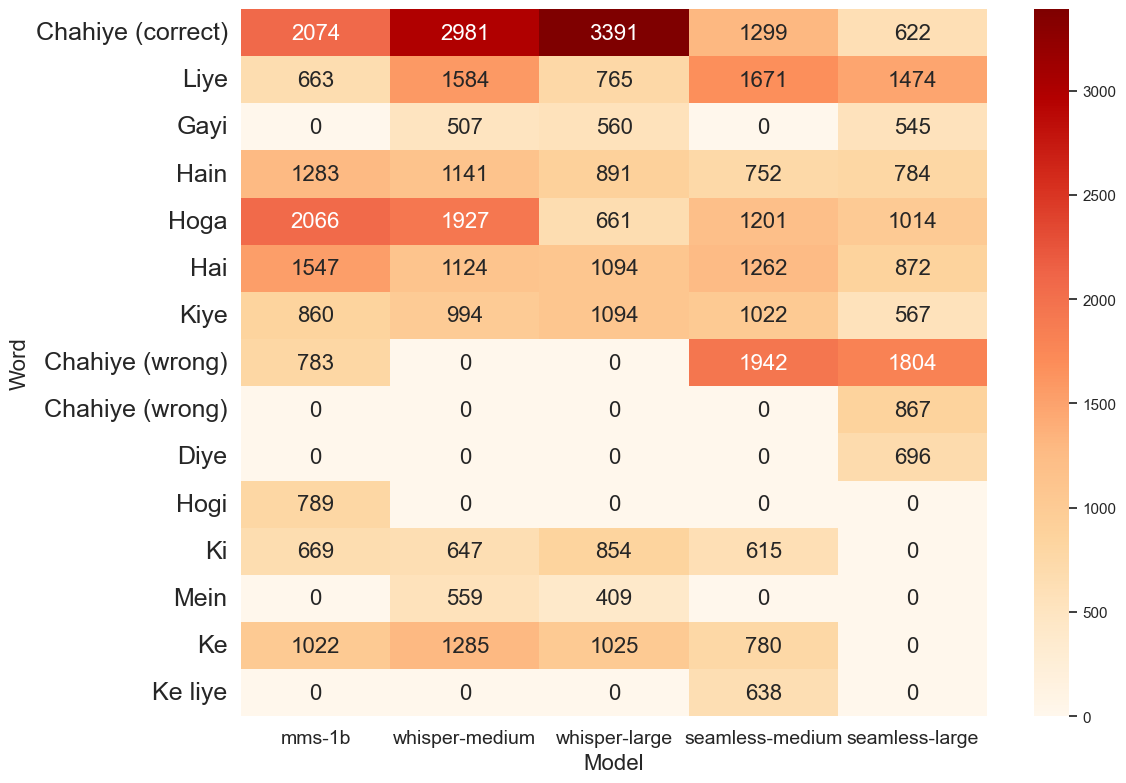

In [338]:
import matplotlib.pyplot as plt
import seaborn as sns
import arabic_reshaper
from bidi.algorithm import get_display
import matplotlib.font_manager as fm
import pandas as pd

def generate_comparative_heatmap(wrong_words_dicts, model_names, top_n=10, filename="heatmap_comparison.png"):
    assert len(wrong_words_dicts) == len(model_names), "Mismatch between number of models and model names"

    all_words = set()
    for wrong_words in wrong_words_dicts:
        del wrong_words["ہ"]
        top_words = dict(wrong_words.most_common(top_n))
        all_words.update(top_words.keys())
    
    all_words = list(all_words)
    data = pd.DataFrame(index=all_words)

    for wrong_words, model_name in zip(wrong_words_dicts, model_names):
        top_words = dict(wrong_words.most_common(top_n))
        data[model_name] = [top_words.get(word, 0) for word in all_words]
    print(data.index)
    data.index = data.index.map(lambda x: get_display(arabic_reshaper.reshape(x)))
    data.index = ['Chahiye (correct)', 'Liye', 'Gayi', 'Hain', 'Hoga', 'Hai', 'Kiye', 'Chahiye (wrong)', 'Chahiye (wrong)',
               'Diye', 'Hogi', 'Ki', 'Mein', 'Ke', 'Ke liye']

    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(data, annot=True, cmap='OrRd', fmt='d', annot_kws={"size": 16})


    ax.set_yticklabels(ax.get_yticklabels(), fontsize=18, rotation=0, ha='right')

    plt.xlabel('Model', fontsize=16)
    plt.ylabel('Word', fontsize=16)
    plt.xticks(fontsize=14)

    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()


generate_comparative_heatmap([mms_1b_, whisper_medium_, whisper_large_, seamless_medium_, seamless_large_],
                             ["mms-1b", "whisper-medium", "whisper-large", "seamless-medium", "seamless-large"],
                             filename="heatmap_comparison-ft.png")


Error counts for mms-1b:
Insertions: 1
Deletions: 839
Substitutions: 14552
Total Errors: 15392

Error counts for whisper-medium:
Insertions: 1
Deletions: 1598
Substitutions: 14435
Total Errors: 16034

Error counts for whisper-large:
Insertions: 3
Deletions: 1641
Substitutions: 13716
Total Errors: 15360

Error counts for seamless-medium:
Insertions: 3
Deletions: 1102
Substitutions: 14262
Total Errors: 15367

Error counts for seamless-large:
Insertions: 4
Deletions: 1675
Substitutions: 13665
Total Errors: 15344


/var/folders/rn/ny91mvp14tl5dnm6b6bcvnmw0000gn/T/ipykernel_74587/1625450884.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y=error_type, data=df, palette='pastel')


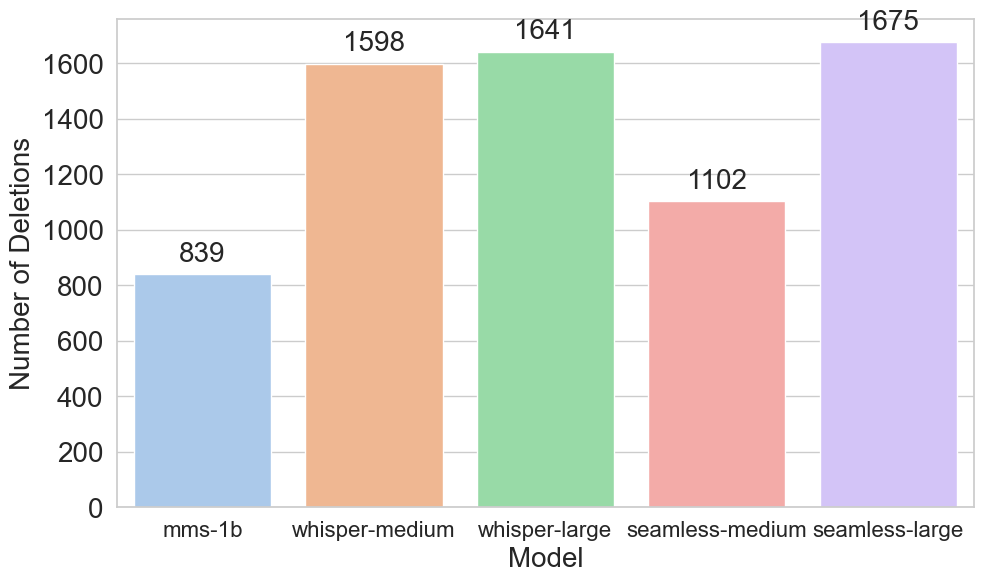

/var/folders/rn/ny91mvp14tl5dnm6b6bcvnmw0000gn/T/ipykernel_74587/1625450884.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y=error_type, data=df, palette='pastel')


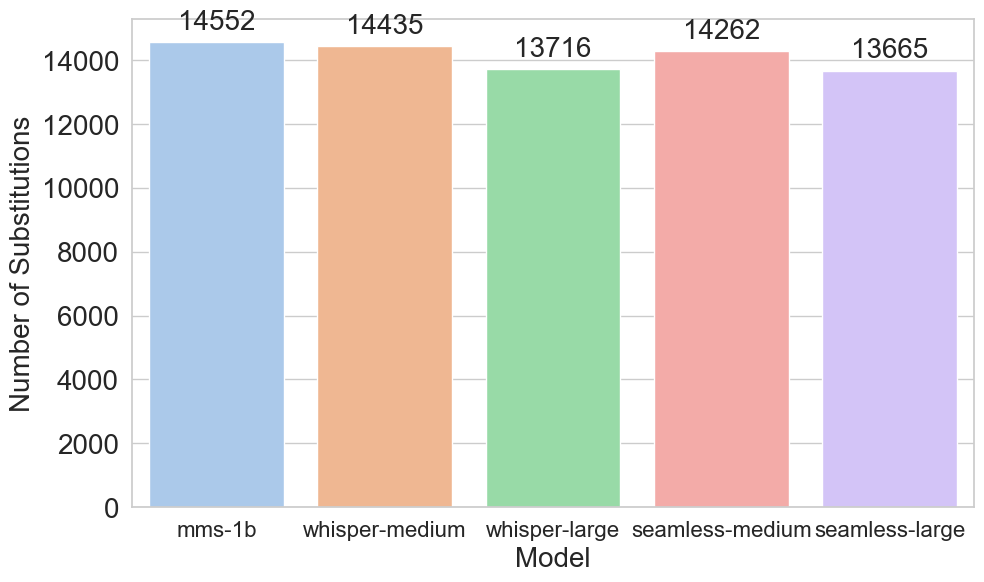

In [232]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from difflib import SequenceMatcher

def compute_error_counts(csalt, pred):
    total_insertions = 0
    total_deletions = 0
    total_substitutions = 0

    for csalt_sentence, pred_sentence in zip(csalt, pred):
        csalt_words = csalt_sentence.split()
        pred_words = pred_sentence.split()

        s = SequenceMatcher(None, csalt_words, pred_words)

        for tag, i1, i2, j1, j2 in s.get_opcodes():
            if tag == 'replace':
                num_substitutions = max(i2 - i1, j2 - j1)
                total_substitutions += num_substitutions
            elif tag == 'delete':
                num_deletions = i2 - i1
                total_deletions += num_deletions
            elif tag == 'insert':
                num_insertions = j2 - j1
                total_insertions += num_insertions

    total_errors = total_insertions + total_deletions + total_substitutions
    return total_insertions, total_deletions, total_substitutions, total_errors

def compute_error_counts_for_models(models, model_names, csalt):
    results = []
    for model_pred, model_name in zip(models, model_names):
        insertions, deletions, substitutions, total_errors = compute_error_counts(csalt, model_pred)
        results.append({
            'Model': model_name,
            'Insertions': insertions,
            'Deletions': deletions,
            'Substitutions': substitutions,
            'Total Errors': total_errors
        })
        print(f"\nError counts for {model_name}:")
        print(f"Insertions: {insertions}")
        print(f"Deletions: {deletions}")
        print(f"Substitutions: {substitutions}")
        print(f"Total Errors: {total_errors}")
    return results

def plot_error_type_bar_chart(results, error_type, filename=None):
    # Convert results to DataFrame
    df = pd.DataFrame(results)

    # Check that the error_type is valid
    if error_type not in ['Insertions', 'Deletions', 'Substitutions']:
        raise ValueError("error_type must be 'Insertions', 'Deletions', or 'Substitutions'")

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    # Create bar plot for the specified error type
    ax = sns.barplot(x='Model', y=error_type, data=df, palette='pastel')

    # Customize the plot
    plt.xlabel('Model', fontsize=20)
    plt.ylabel(f'Number of {error_type}', fontsize=20)
    plt.xticks(rotation=0, fontsize=16)
    plt.yticks(fontsize=20)

    # Display the value on top of each bar
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(p.get_x() + p.get_width() / 2, height),
                    xytext=(0, 5),  # Offset text by 5 points vertically
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=20)

    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300)
    plt.show()

# Replace the placeholders with your actual data
# For example:
# csalt = [...]  # List of reference sentences
# mms_1b_ = [...]  # List of predictions from mms-1b model
# whisper_medium_ = [...]  # Predictions from whisper-medium model
# ... and so on for other models

# Your models and their names
models = [mms_1b_, whisper_medium_, whisper_large_, seamless_medium_, seamless_large_]
models_ft = [mms_1b_ft, whisper_medium_ft, whisper_large_ft, seamless_medium_ft, seamless_large_ft]
model_names = ["mms-1b", "whisper-medium", "whisper-large", "seamless-medium", "seamless-large"]

# Compute error counts for each model
results = compute_error_counts_for_models(models, model_names, csalt)

# Plot deletions per model
plot_error_type_bar_chart(results, error_type='Deletions', filename='deletions_per_model.png')

# Plot substitutions per model
plot_error_type_bar_chart(results, error_type='Substitutions', filename='substitutions_per_model.png')



Error counts for mms-1b:
Insertions: 1
Deletions: 844
Substitutions: 14552
Total Errors: 15397

Error counts for whisper-medium:
Insertions: 1
Deletions: 1598
Substitutions: 14435
Total Errors: 16034

Error counts for whisper-large:
Insertions: 3
Deletions: 1641
Substitutions: 13716
Total Errors: 15360

Error counts for seamless-medium:
Insertions: 3
Deletions: 1102
Substitutions: 14262
Total Errors: 15367

Error counts for seamless-large:
Insertions: 4
Deletions: 1675
Substitutions: 13665
Total Errors: 15344


/var/folders/rn/ny91mvp14tl5dnm6b6bcvnmw0000gn/T/ipykernel_74587/669142837.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y=error_type, data=df, palette='pastel')


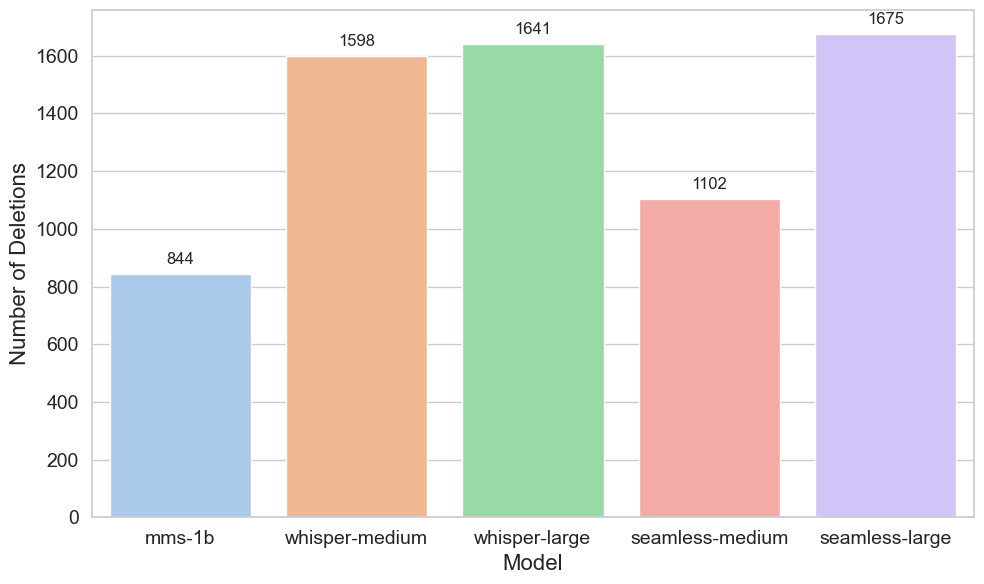

/var/folders/rn/ny91mvp14tl5dnm6b6bcvnmw0000gn/T/ipykernel_74587/669142837.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y=error_type, data=df, palette='pastel')


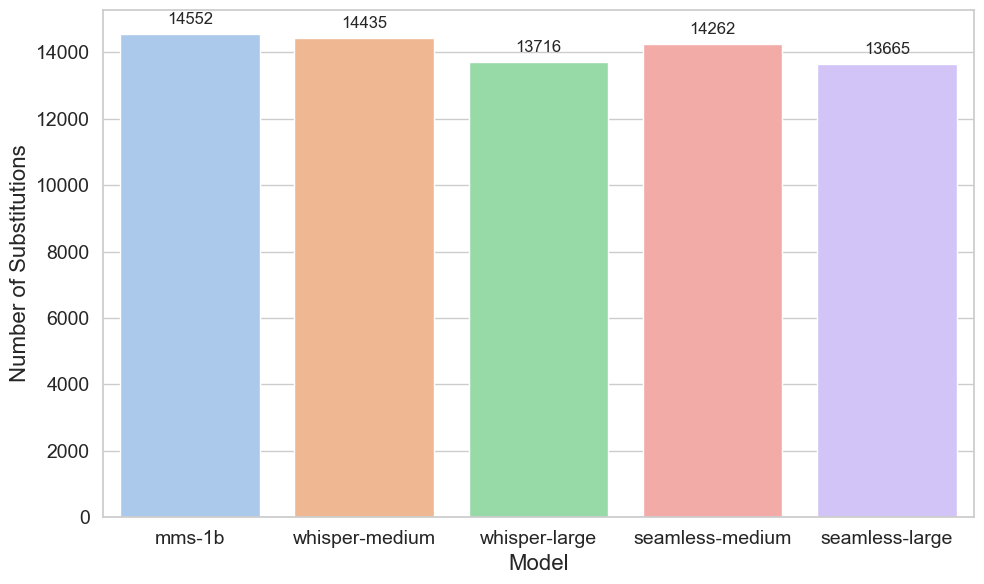

In [189]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from difflib import SequenceMatcher

def compute_error_counts(csalt, pred):
    total_insertions = 0
    total_deletions = 0
    total_substitutions = 0

    for csalt_sentence, pred_sentence in zip(csalt, pred):
        csalt_words = csalt_sentence.split()
        pred_words = pred_sentence.split()

        s = SequenceMatcher(None, csalt_words, pred_words)

        for tag, i1, i2, j1, j2 in s.get_opcodes():
            if tag == 'replace':
                num_substitutions = max(i2 - i1, j2 - j1)
                total_substitutions += num_substitutions
            elif tag == 'delete':
                num_deletions = i2 - i1
                total_deletions += num_deletions
            elif tag == 'insert':
                num_insertions = j2 - j1
                total_insertions += num_insertions

    total_errors = total_insertions + total_deletions + total_substitutions
    return total_insertions, total_deletions, total_substitutions, total_errors

def compute_error_counts_for_models(models, model_names, csalt):
    results = []
    for model_pred, model_name in zip(models, model_names):
        insertions, deletions, substitutions, total_errors = compute_error_counts(csalt, model_pred)
        results.append({
            'Model': model_name,
            'Insertions': insertions,
            'Deletions': deletions,
            'Substitutions': substitutions,
            'Total Errors': total_errors
        })
        print(f"\nError counts for {model_name}:")
        print(f"Insertions: {insertions}")
        print(f"Deletions: {deletions}")
        print(f"Substitutions: {substitutions}")
        print(f"Total Errors: {total_errors}")
    return results

def plot_error_type_bar_chart(results, error_type, filename=None):
    # Convert results to DataFrame
    df = pd.DataFrame(results)

    # Check that the error_type is valid
    if error_type not in ['Insertions', 'Deletions', 'Substitutions']:
        raise ValueError("error_type must be 'Insertions', 'Deletions', or 'Substitutions'")

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    # Create bar plot for the specified error type
    ax = sns.barplot(x='Model', y=error_type, data=df, palette='pastel')

    # Customize the plot
    plt.xlabel('Model', fontsize=16)
    plt.ylabel(f'Number of {error_type}', fontsize=16)
    plt.xticks(rotation=0, fontsize=14)
    plt.yticks(fontsize=14)

    # Display the value on top of each bar
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(p.get_x() + p.get_width() / 2, height),
                    xytext=(0, 5),  # Offset text by 5 points vertically
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300)
    plt.show()

# Replace the placeholders with your actual data
# For example:
# csalt = [...]  # List of reference sentences
# mms_1b_ = [...]  # List of predictions from mms-1b model
# whisper_medium_ = [...]  # Predictions from whisper-medium model
# ... and so on for other models

# Your models and their names
models = [mms_1b_, whisper_medium_, whisper_large_, seamless_medium_, seamless_large_]
model_names = ["mms-1b", "whisper-medium", "whisper-large", "seamless-medium", "seamless-large"]

# Compute error counts for each model
results = compute_error_counts_for_models(models, model_names, csalt)

# Plot deletions per model
plot_error_type_bar_chart(results, error_type='Deletions', filename='deletions_per_model.png')

# Plot substitutions per model
plot_error_type_bar_chart(results, error_type='Substitutions', filename='substitutions_per_model.png')



Error counts for mms-1b (Non-Fine-Tuned):
Insertions: 1
Deletions: 839
Substitutions: 14552
Total Errors: 15392

Error counts for whisper-medium (Non-Fine-Tuned):
Insertions: 1
Deletions: 1598
Substitutions: 14435
Total Errors: 16034

Error counts for whisper-large (Non-Fine-Tuned):
Insertions: 3
Deletions: 1641
Substitutions: 13716
Total Errors: 15360

Error counts for seamless-medium (Non-Fine-Tuned):
Insertions: 3
Deletions: 1102
Substitutions: 14262
Total Errors: 15367

Error counts for seamless-large (Non-Fine-Tuned):
Insertions: 4
Deletions: 1675
Substitutions: 13665
Total Errors: 15344

Error counts for mms-1b (Fine-Tuned):
Insertions: 4
Deletions: 338
Substitutions: 15067
Total Errors: 15409

Error counts for whisper-medium (Fine-Tuned):
Insertions: 0
Deletions: 589
Substitutions: 14805
Total Errors: 15394

Error counts for whisper-large (Fine-Tuned):
Insertions: 0
Deletions: 1234
Substitutions: 14164
Total Errors: 15398

Error counts for seamless-medium (Fine-Tuned):
Insertio

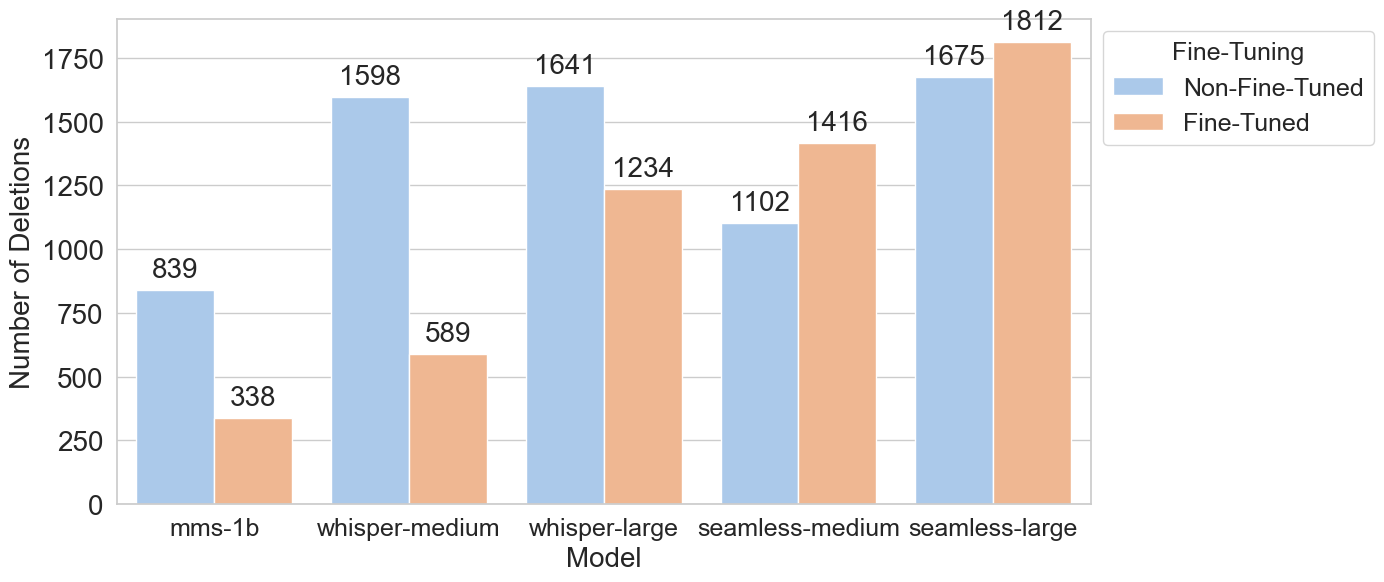

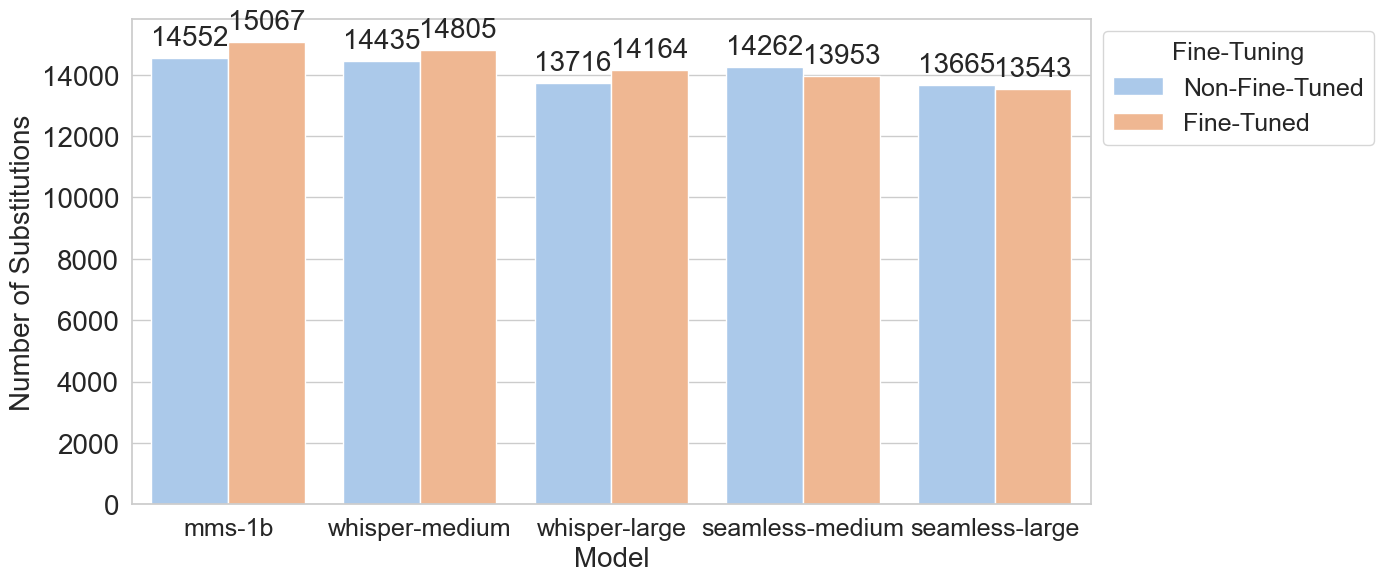

In [236]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from difflib import SequenceMatcher

def compute_error_counts(csalt, pred):
    total_insertions = 0
    total_deletions = 0
    total_substitutions = 0

    for csalt_sentence, pred_sentence in zip(csalt, pred):
        csalt_words = csalt_sentence.split()
        pred_words = pred_sentence.split()

        s = SequenceMatcher(None, csalt_words, pred_words)

        for tag, i1, i2, j1, j2 in s.get_opcodes():
            if tag == 'replace':
                num_substitutions = max(i2 - i1, j2 - j1)
                total_substitutions += num_substitutions
            elif tag == 'delete':
                num_deletions = i2 - i1
                total_deletions += num_deletions
            elif tag == 'insert':
                num_insertions = j2 - j1
                total_insertions += num_insertions

    total_errors = total_insertions + total_deletions + total_substitutions
    return total_insertions, total_deletions, total_substitutions, total_errors

def compute_error_counts_for_models(models, model_names, csalt, fine_tuned=False):
    results = []
    for model_pred, model_name in zip(models, model_names):
        insertions, deletions, substitutions, total_errors = compute_error_counts(csalt, model_pred)
        results.append({
            'Model': model_name,
            'Fine-Tuning': 'Fine-Tuned' if fine_tuned else 'Non-Fine-Tuned',
            'Insertions': insertions,
            'Deletions': deletions,
            'Substitutions': substitutions,
            'Total Errors': total_errors
        })
        print(f"\nError counts for {model_name} ({'Fine-Tuned' if fine_tuned else 'Non-Fine-Tuned'}):")
        print(f"Insertions: {insertions}")
        print(f"Deletions: {deletions}")
        print(f"Substitutions: {substitutions}")
        print(f"Total Errors: {total_errors}")
    return results

def plot_joint_error_type_bar_chart(results, error_type, filename=None):
    # Convert results to DataFrame
    df = pd.DataFrame(results)

    # Check that the error_type is valid
    if error_type not in ['Insertions', 'Deletions', 'Substitutions']:
        raise ValueError("error_type must be 'Insertions', 'Deletions', or 'Substitutions'")

    sns.set(style="whitegrid")
    plt.figure(figsize=(14, 6))  # Increased figure width

    # Create a grouped bar plot for the specified error type
    ax = sns.barplot(x='Model', y=error_type, hue='Fine-Tuning', data=df, palette='pastel')

    # Customize the plot
    plt.xlabel('Model', fontsize=20)
    plt.ylabel(f'Number of {error_type}', fontsize=20)
    plt.xticks(rotation=0, fontsize=18)
    plt.yticks(fontsize=20)

    # Move the legend outside the plot
    plt.legend(title='Fine-Tuning', title_fontsize=18, fontsize=18, loc='upper left', bbox_to_anchor=(1, 1))

    # Display the value on top of each bar, skip bars with zero height
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f'{int(height)}',
                        xy=(p.get_x() + p.get_width() / 2, height),
                        xytext=(0, 5),  # Offset text by 5 points vertically
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=20)

    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# Replace the placeholders with your actual data
# csalt = [...]  # List of reference sentences
# mms_1b_ = [...]  # Predictions from mms-1b model (non-fine-tuned)
# mms_1b_ft = [...]  # Predictions from mms-1b model (fine-tuned)
# ... and so on for other models

# Your models and their names
models = [mms_1b_, whisper_medium_, whisper_large_, seamless_medium_, seamless_large_]
models_ft = [mms_1b_ft, whisper_medium_ft, whisper_large_ft, seamless_medium_ft, seamless_large_ft]
model_names = ["mms-1b", "whisper-medium", "whisper-large", "seamless-medium", "seamless-large"]

# Compute error counts for non-fine-tuned models
results_nft = compute_error_counts_for_models(models, model_names, csalt, fine_tuned=False)

# Compute error counts for fine-tuned models
results_ft = compute_error_counts_for_models(models_ft, model_names, csalt, fine_tuned=True)

# Combine the results
combined_results = results_nft + results_ft

# Plot deletions per model
plot_joint_error_type_bar_chart(combined_results, error_type='Deletions', filename='deletions_per_model_joint.png')

# Plot substitutions per model
plot_joint_error_type_bar_chart(combined_results, error_type='Substitutions', filename='substitutions_per_model_joint.png')
